<a href="https://colab.research.google.com/github/marioskyriacou/Bipartite_Graphs_Manual/blob/main/Bipartite_Graphs_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# Installations
!pip install numpyro
!pip install funsor

In [2]:
# Main Libraries
import pandas as pd
import numpy as np
import numpyro
import os
import jax
import time
import pickle
import networkx as nx
import matplotlib
import seaborn as sns

print(f'Pandas: {pd.__version__}')
print(f'Numpy: {np.__version__}')
print(f'Numpyro: {numpyro.__version__}')
print(f'Networkx: {nx.__version__}')
print(f'Jax: {jax.__version__} // Jax Devices:{jax.devices()[0]}')
print(f'Pickle: {pickle.format_version}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')



Pandas: 2.2.2
Numpy: 1.26.4
Numpyro: 0.15.3
Networkx: 3.4.2
Jax: 0.4.33 // Jax Devices:TFRT_CPU_0
Pickle: 4.0
Matplotlib: 3.8.0
Seaborn: 0.13.2


In [3]:
# Visualization
import matplotlib.pyplot as plt

# Jax
from jax import numpy as jnp
from jax import random as jrandom
from jax import vmap
import jax.scipy.special as special
import jax.random as random


# NumpyRO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.infer import (
    MCMC,
    HMC,
    MixedHMC,
    init_to_value,
    NUTS,
    DiscreteHMCGibbs
)
from numpyro.infer import Predictive
from numpyro.distributions import constraints

## Generate a graph from the prior model
from jax import random as random_jx
from jax import lax, jit, ops
from numpyro.infer import Predictive

# table creation
from tabulate import tabulate


# Bipartite Main Functions

## Simulate Graph

In [4]:
# I create the etBFRY function by making a class
class etBFRY(numpyro.distributions.Distribution):
    arg_constraints = {
        # "sigma": constraints.unit_interval,
        # "alpha": constraints.positive,
        "tau": constraints.positive
    }
    support = constraints.positive
    reparametrized_params = ["sigma", "alpha", "tau"]

    def __init__(self, L, alpha, sigma, tau):
        #read parameters
        self.L = L
        self.sigma = sigma
        self.tau = tau
        self.alpha = alpha
        self.t_as = (self.sigma*self.L/self.alpha)**(1.0/self.sigma)
        super().__init__(batch_shape = (1, self.L), event_shape=())

    def sample(self, key, sample_shape=()):
        #generate from the distribution
        shape = sample_shape + self.batch_shape
        G_dist = dist.Gamma(1.0-self.sigma, 1.0)
        G = G_dist.sample(key,shape) if isinstance(self.sigma, float) else G_dist.sample(key,(1,))
        U_dist = dist.Uniform()
        U = U_dist.sample(key,shape)
        R = G*((1.0-U)*(self.t_as+self.tau)**self.sigma + U*self.tau**self.sigma)**(-1.0/self.sigma)
        return R

    def log_prob(self, value):
      #evaluate the log probability density
      # return jnp.log(self.sigma)+(-1-self.sigma)*jnp.log(value)-self.tau*value+jnp.log(1-jnp.exp(-value*self.t_as))-special.gammaln(1-self.sigma)-jnp.log((self.tau+self.t_as)**self.sigma-self.tau**self.sigma)
      return jnp.log(self.sigma / ((self.tau+self.t_as)**self.sigma-self.tau**self.sigma))+(-1-self.sigma)*jnp.log(value)-self.tau*value+jnp.log(1-jnp.exp(-value*self.t_as))-special.gammaln(1-self.sigma)



In [5]:
def check_alpha(alpha):
    if alpha is None:
      #create a smaple from the below distribution , if a value is not given
      # Distributions: dist.HalfNormal(20) (mean=talpha*1.25=30*1.25 ~37) (var = (1-2pi)scale*2) //  dist.HalfCauchy(20) // dist.Gamma(90,3)
      alpha = numpyro.sample("alpha", dist.HalfNormal(20))
    else:
      #if you generate a graph
      alpha = numpyro.deterministic("alpha",alpha) # if given a value

    return alpha

def check_alpha_prime(alpha_prime):
    #create a smaple from the below distribution , if a value is not given
    #Distributions:  dist.HalfNormal(20) (mean=talpha*1.25=30*1.25 ~37) (var = (1-2pi)scale*2) //  dist.HalfCauchy(20) // dist.Gamma(90,3)
    if alpha_prime is None:
      alpha_prime = numpyro.sample("alpha_prime", dist.HalfNormal(20))
    else:
      #if you generate a graph
      alpha_prime = numpyro.deterministic("alpha_prime",alpha_prime) # if given a value

    return alpha_prime

In [6]:
def check_sigma(sigma):
  if sigma is None:
    #create a smaple from the below distribution , if a value is not given
    # Distributions:  dist.HalfNormal(1) 1 - sigma ~ Improper Unif //  dist.Uniform(0,1) //  TruncatedDistribution(dist.Normal(1,1), low=0, high=1) //
    # truncated_normal_model(num_observations, high=1, x=None) //  TruncatedNormal(loc=1, scale=1,low=0, high=1) //  dist.TruncatedDistribution(dist.Normal(0.5, 1), low=0.01, high=2)
    sigma = numpyro.sample("sigma", dist.Beta(2,10)) # (1/9, 1) (1,4)
  else:
    sigma = numpyro.deterministic("sigma", sigma)
  return sigma


def check_sigma_prime(sigma_prime):
   #create a smaple from the below distribution , if a value is not given
   # Distributions: dist.HalfNormal(1) 1 - sigma ~ Improper Unif // dist.Uniform(0,1) // TruncatedDistribution(dist.Normal(1,1), low=0, high=1)
   # truncated_normal_model(num_observations, high=1, x=None) // TruncatedNormal(loc=1, scale=1,low=0, high=1) //
   # dist.TruncatedDistribution(dist.Normal(0.5, 1), low=0.01, high=2)
  if sigma_prime is None:
    sigma_prime = numpyro.sample("sigma_prime", dist.Beta(2,10)) # 1/9, 1
  else:
    sigma_prime = numpyro.deterministic("sigma_prime",sigma_prime)
  return sigma_prime

In [7]:
def check_tau(tau):
    if tau is None:
      #create a smaple from the below distribution , if a value is not given
      tau = numpyro.sample("tau", dist.HalfNormal(1))
    else:
      tau = numpyro.deterministic("tau",tau)
    return tau

def check_tau_prime(tau_prime):
   #create a smaple from the below distribution , if a value is not given
    if tau_prime is None:
      tau_prime = numpyro.sample("tau_prime", dist.HalfNormal(1))
    else:
      tau_prime = numpyro.deterministic("tau_prime",tau_prime)
    return tau_prime

In [8]:
def check_a(a, p):
  if a is None:
    a = numpyro.sample("a", dist.HalfNormal(2), sample_shape=(p, ))
  else:
    a = numpyro.deterministic("a", a)
  return a


def check_a_prime(a_prime, p):
  if a_prime is None:
    a_prime = numpyro.sample("a_prime", dist.HalfNormal(2), sample_shape=(p, ))
  else:
    a_prime = numpyro.deterministic("a_prime", a_prime)
  return a_prime

In [9]:
def check_b(b, p):
  if b is None:
    b = numpyro.sample("b", dist.HalfNormal(2), sample_shape=(p, ))
    # b = numpyro.sample("b", dist.Gamma(0.01, 0.01), sample_shape=(p,))
  else:
    b = numpyro.deterministic("b", b)
  return b

def check_b_prime(b_prime, p):
  if b_prime is None:
    b_prime = numpyro.sample("b_prime", dist.HalfNormal(2), sample_shape=(p, ))
    # b = numpyro.sample("b", dist.Gamma(0.01, 0.01), sample_shape=(p,))
  else:
    b_prime = numpyro.deterministic("b_prime", b_prime)
  return b_prime

In [10]:
def Bibartite_netwokr(args):
  L, L_prime = args['L'], args['L_prime']
  p=args['p'] # number of communities

  #hyperparameters of the BFRY upper & bottom
  tau, tau_prime = args['tau'], args['tau_prime']
  sigma, sigma_prime = args['sigma'],  args['sigma_prime']
  alpha, alpha_prime = args['alpha'], args['alpha_prime']
  wi0, wj0 = args['wi0'], args['wj0']

  # Upper & bottom hyperparameters of the scores (levels of affiliations to communities)
  a, a_prime= args['a'], args['a_prime']
  b, b_prime = args['b'], args['b_prime']
  scores, scores_prime = args['scores'], args['scores_prime']

  #Check given hyperparameters
  tau, tau_prime = check_tau(tau), check_tau_prime(tau_prime)
  sigma, sigma_prime = check_sigma(sigma), check_sigma_prime(sigma_prime)
  alpha, alpha_prime = check_alpha(alpha), check_alpha_prime(alpha_prime)
  a, a_prime = check_a(a, p), check_a_prime(a_prime, p)
  b, b_prime = check_b(b, p), check_b_prime(b_prime, p)

  print(f'Upper hyperparameters:\n tau:{tau}, sigma:{sigma}, alpha:{alpha}, a:{a}, b:{b}')
  print(f'Bottom hyperparameters:\n tau:{tau_prime}, sigma:{sigma_prime}, alpha:{alpha_prime}, a:{a_prime}, b:{b_prime}')

  # adjacency matrix
  Z_obs=args['Z_obs']

  ####### Affiliation Scorres for Upper Nodes & Wi0 ###########
  if scores is None:
      # Ditributions: dist.Beta(a, b), sample_shape=(L,p) // dist.Gamma(a, b), sample_shape=(L, p) // dist.HalfNormal(4), sample_shape=(L,)
      scores = numpyro.sample("scores", dist.Gamma(a, b), sample_shape=(L, )) # if a, b vectors
  else:
      scores = numpyro.deterministic("scores", scores)


  if wi0 is None:
    wi0 = numpyro.sample("wi0", etBFRY(L, alpha, sigma, tau))
    wi0 = wi0.reshape(L,)
  else:
    wi0 = numpyro.deterministic("wi0", wi0)

  ####### Affiliation Scorres for Bottom Nodes & Wj0 ###########
  if scores_prime is None:
      #Distributions: dist.Beta(a, b), sample_shape=(L,p) // dist.Gamma(a_prime, b_prime), sample_shape=(L_prime, p) //  dist.HalfNormal(4), sample_shape=(L,)
      scores_prime = numpyro.sample("scores_prime", dist.Gamma(a, b), sample_shape=(L_prime, )) # if a, b vectors
  else:
      scores_prime = numpyro.deterministic("scores_prime", scores_prime)

  if wj0 is None:
    wj0 = numpyro.sample("wj0", etBFRY(L_prime, alpha_prime, sigma_prime, tau_prime))
    wj0=wj0.reshape(L_prime,)
  else:
    wj0 = numpyro.deterministic("wj0", wj0)

  ########## Adjanceny Matrix ############

  Wi = jnp.transpose(jnp.multiply(jnp.transpose(scores), wi0))
  Wj = jnp.transpose(jnp.multiply(jnp.transpose(scores_prime), wj0))
  W_adj = jnp.matmul(Wi, jnp.transpose(Wj))## (L,T,p) x (L_prime,T,p)

  numpyro.sample("Z_obs", dist.Bernoulli(1-jnp.exp(-2*W_adj)), obs=Z_obs)
  #numpyro.sample("N_obs", dist.Poisson(ww), obs=N_obs)


**Gegree Distribution**

In [11]:
def plt_deg_distr(deg, sigma='NA', binned=False):
    # Plot Degree Distributions:
    # Count the degrees of each nodes for one type of nodes (A or B) -> eliminate the 0 connections
    # plot the degree distribution
    #
    deg = deg[deg > 0]
    num_nodes = len(deg)
    freq = pd.Series(deg).value_counts().to_dict()  # Count the occurrences of each degree

    if binned == True:
        freq = [x / num_nodes for x in list(freq.values())] ## Normalize frequency values
        bins = np.exp(np.linspace(np.log(min(freq)), np.log(max(freq)), 20)) #logarithmic bins for frequency values
        sizebins = (bins[1:] - bins[:-1]) #width of each bin
        # sizebins = np.append(sizebins, 1)
        counts = np.histogram(freq, bins=bins)[0]
        freq = counts/sizebins #Normalize counts by bin size
        freq = freq/sum(freq) #Further normalize frequency so the total sums to 1
        plt.figure()
        plt.plot(bins[:-1], freq, 'bo', label='empirical')
        plt.legend()
    else:

        plt.figure()
        plt.plot(list(freq.keys()), [np.exp(np.log(x) - np.log(num_nodes)) for x in list(freq.values())], 'bo')
        plt.legend()

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('deg')
    plt.ylabel('frequency')

    return freq

**Add Zeros**

In [12]:
def add_zero_adj_matrix(adj_matrix, ratio = 1.1):
  # add zeros to the adj matrix based on a given ratio
  print(f'Adj matrix: {adj_matrix.shape} ')

  L_upper, L_lower = adj_matrix.shape[0], adj_matrix.shape[1] # Dimenshion Shapes
  L_upper_new, L_lower_new = int(L_upper * 1.1), int(L_lower * ratio) # ratio of update shape 1.5
  # Create new matrix
  matrix_new = np.zeros((L_upper_new, L_lower_new))
  matrix_new[0:L_upper, 0:L_lower]  = np.array(adj_matrix)
  print(f'New Adj matrix: {matrix_new.shape} ')
  return matrix_new

## **Infer Traces Plot**

In [13]:
def plot_traces(args_mcmc, samples, args):
    # Plot the trace plots for MCMC samples of specified parameters
    # Variables needed/ # Calculate the number of iterations for each parameter
    num_chains=args_mcmc['num_chains']
    iters = int(samples['wi0'].shape[0] / num_chains)
    iters_prime = int(samples['wj0'].shape[0] / num_chains)

    # Identify the parameters that need to be plot
    parameters_list = ['alpha', 'sigma', 'tau', 'a', 'b', 'alpha_prime', 'sigma_prime', 'tau_prime', 'a_prime', 'b_prime']
    plt_params = [key for key, value in args_mcmc.items() if args_mcmc[key] is None and key in parameters_list]

    # Plot each parameter in a graph
    for param in plt_params:
      ## Check if the parameter has multiple subplots
      if len(samples[param].shape) > 1:
        num_subplots = samples[param].shape[1]
        fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))
        axes = np.array(axes).flatten()

        for i in range(num_subplots):
            for j in range(num_chains):
              #Plot the MCMC trace for each chain
              axes[i].plot(np.arange(iters), samples[param][:, i][j*iters_prime:(j+1)*iters_prime], 'o-', alpha = 0.8,  label=f'{param}[{i}]')
              #plt.plot(np.arange(iters), samples[param][i*iters:(i+1)*iters], 'o-')
            axes[i].axhline(y=args[param][i], color='red')
            axes[i].set_title(f'{param}[{i}]')
      else:
        #For single-dimensional parameters, create a new figure
        plt.figure()
        for i in range(num_chains):
          plt.plot(np.arange(iters_prime), samples[param][i*iters_prime:(i+1)*iters_prime], 'o-', alpha = 0.8)
        plt.axhline(y=np.mean(args[param]), color='red')
        plt.title(param)


## **Infer HIstogram Plots**

In [14]:
def plot_MCMC_histograms(args_mcmc, samples, args):
    # Plot the trace plots for MCMC samples of specified parameters
    # Variables needed/ # Calculate the number of iterations for each parameter

    # Varibles
    num_bins=20
    num_chains=args_mcmc['num_chains']
    iters = int(samples['wi0'].shape[0] / num_chains)
    iters_prime = int(samples['wj0'].shape[0] / num_chains)

    # Identify the parameters that need to be plot
    parameters_list = ['alpha', 'sigma', 'tau', 'a', 'b', 'alpha_prime', 'sigma_prime', 'tau_prime', 'a_prime', 'b_prime']
    plt_params = [key for key, value in args_mcmc.items() if args_mcmc[key] is None and key in parameters_list]

    # Plot each parameter in a graph
    for param in plt_params:
      if len(samples[param].shape) > 1:
        num_subplots = samples[param].shape[1]
        fig, axes = plt.subplots(1, num_subplots, figsize=(15, 5))
        axes = np.array(axes).flatten()

        for i in range(num_subplots):
            for j in range(num_chains):
               #Plot the MCMC histogram  for each chain
              axes[i].hist(samples[param][:, i][j*iters_prime:(j+1)*iters_prime], num_bins, alpha = 0.5, label=f'{param}[{i}]')
            axes[i].axvline(x=args[param][i], color='red')
            axes[i].set_title(f'{param}[{i}]')
      else:

        plt.figure()
        for i in range(num_chains):
          #For single-dimensional parameters, create a new figure
          plt.hist(samples[param][i*iters:(i+1)*iters], num_bins, alpha = 0.8, label = str(param) )
        plt.axvline(x=np.mean(args[param]), color='red')
        plt.title(param)


## Posterior Distribution PLots (Log Plots)

In [15]:
def Posterior_distribution(graph_draws, num_samples, thinning, num_chains, L, L_prime):
  # Plot the posterior distribution for the top m nodes based on estimated weights wi0 and wj0.
  tgraph_index = 1
  m = 50 ## Number of top nodes to plot

  # Extract true and estimated values for Wi0
  Wi0 = graph_draws['wi0']
  wi0_est = samples['wi0']
  # Reshape and calculate the 95% highest posterior density interval (HPDI) for Wi0
  wi0_est = wi0_est.reshape(int(num_samples/thinning*num_chains), L)
  wi0_est = hpdi(wi0_est, prob=0.95)

 # Extract true and estimated values for Wj0
  Wj0 = graph_draws['wj0']
  wj0_est = samples['wj0']
  # Reshape and calculate the 95% highest posterior density interval (HPDI) for Wi0
  wj0_est = wj0_est.reshape(int(num_samples/thinning*num_chains), L_prime)
  wj0_est = hpdi(wj0_est, prob=0.95)

  print(f'Wi0 Shape:{wi0_est.shape}\nWj0 Shape:{wj0_est.shape}')

  #indices of the top m nodes by sorting Wi0 in decreasing order
  ind_max_wi0 = np.argsort(-Wi0[tgraph_index, 0, :])[:m]
  w0i_ci_max = wi0_est[:, ind_max_wi0]

  #indices of the top m nodes by sorting Wj0 in decreasing order
  ind_max_wj0 = np.argsort(-Wj0[tgraph_index, 0, :])[:m]
  w0j_ci_max = wj0_est[:, ind_max_wj0]

  #x-axis for each node index and y-axis for confidence intervals
  x = [(i, i) for i in range(m)]
  y = [(w0i_ci_max[0, i], w0i_ci_max[1, i]) for i in range(m)]
  y_prime = [(w0j_ci_max[0, i], w0j_ci_max[1, i]) for i in range(m)]

  #Plots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

  # Upper Nodes
  for i, j in zip(x, y):
      ax1.plot((i[0], i[1]), (j[0], j[1]), color='blue')
      ax1.scatter(i[0], Wi0[tgraph_index, 0, ind_max_wi0[i[0]]], color='red')

  ax1.plot((i[0], i[1]), (j[0], j[1]), color='blue', label='95% CI')
  ax1.scatter(i[0], Wi0[tgraph_index, 0, ind_max_wi0[i[0]]], color='red', label='true')
  ax1.title.set_text('Upper Nodes')
  ax1.set_xlabel('index of nodes sorted by decreasing wi0')
  ax1.set_ylabel('wi0')

  # Lower Nodes
  for i, j in zip(x, y_prime):
      ax2.plot((i[0], i[1]), (j[0], j[1]), color='blue')
      ax2.scatter(i[0], Wj0[tgraph_index, 0, ind_max_wj0[i[0]]], color='red')

  ax2.plot((i[0], i[1]), (j[0], j[1]), color='blue', label='95% CI')
  ax2.scatter(i[0], Wj0[tgraph_index, 0, ind_max_wj0[i[0]]], color='red', label='true')
  ax2.title.set_text('Lower Nodes')
  ax2.set_xlabel('index of nodes sorted by decreasing wj0')
  ax2.set_ylabel('wj0')

  fig.tight_layout()
  plt.show()


In [16]:
def Posterior_distribution_Log(graph_draws, num_samples, thinning, num_chains, L, L_prime):

  tgraph_index = 1
  m = 50
  # Wi0 estimates
  Wi0 = graph_draws['wi0']
  wi0_est = samples['wi0']
  wi0_est = wi0_est.reshape(int(num_samples/thinning*num_chains), L)
  wi0_est = hpdi(wi0_est, prob=0.95)

  # Wj0 estimates
  Wj0 = graph_draws['wj0']
  wj0_est = samples['wj0']
  wj0_est = wj0_est.reshape(int(num_samples/thinning*num_chains), L_prime)
  wj0_est = hpdi(wj0_est, prob=0.95)
  print(f'Wi0 Shape:{wi0_est.shape}\nWj0 Shape:{wj0_est.shape}')

  ind_min_wi0 = np.argsort(Wi0[tgraph_index, 0, :])[:m]
  w0i_ci_min = wi0_est[:, ind_min_wi0]

  ind_min_wj0 = np.argsort(Wj0[tgraph_index, 0, :])[:m]
  w0j_ci_min = wj0_est[:, ind_min_wj0]

  x = [(i, i) for i in range(m)]
  y = [(w0i_ci_min[0, i], w0i_ci_min[1, i]) for i in range(m)]
  y_prime = [(w0j_ci_min[0, i], w0j_ci_min[1, i]) for i in range(m)]


  #Plots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  # Upper Nodes
  for i, j in zip(x, y):
      ax1.plot((i[0], i[1]), (np.log(j[0]), np.log(j[1])), color='blue')
      ax1.scatter(i[0], np.log(Wi0[tgraph_index, 0, ind_min_wi0[i[0]]]), color='red')
  ax1.plot((i[0], i[1]), (j[0], j[1]), color='blue', label='95% CI')
  ax1.scatter(i[0], np.log(Wi0[tgraph_index, 0, ind_min_wi0[i[0]]]), color='red', label='true')
  ax1.title.set_text('Upper Nodes')
  ax1.set_xlabel('index of nodes sorted by decreasing wi0')
  ax1.set_ylabel('Log_wi0')

  # Lower Nodes
  for i, j in zip(x, y_prime):
      ax2.plot((i[0], i[1]), (np.log(j[0]), np.log(j[1])), color='blue')
      ax2.scatter(i[0], np.log(Wj0[tgraph_index, 0, ind_min_wj0[i[0]]]), color='red')
  ax2.plot((i[0], i[1]), (j[0], j[1]), color='blue', label='95% CI')
  ax2.scatter(i[0], np.log(Wj0[tgraph_index, 0, ind_min_wj0[i[0]]]), color='red', label='true')
  ax2.title.set_text('Lower Nodes')
  ax2.set_xlabel('index of nodes sorted by decreasing wj0')
  ax2.set_ylabel('Log_wj0')

  fig.tight_layout()
  plt.show()


## Predicted Post Degree Distribution

In [17]:
def network_weights_w_wprime(samples_dict, iters, iters_prime, p):
  # Calculate the estimated network weights for upper and lower nodes.
  # Upper Nodes
  W_upper_est = np.zeros((iters, L_mcmc, p))
  for i in range(iters):
    #Multiply each score in `scores` by the corresponding wi0 weight
      W_upper_est[i, :, :] = np.transpose(np.multiply(np.transpose(samples_dict['scores'][i, :, :]), samples_dict['wi0'][i, :]))

  # Lower Nodes
  W_lower_est = np.zeros((iters_prime, L_prime_mcmc, p))
  for j in range(iters_prime):
    #Multiply each score in `scores` by the corresponding wj0 weight
      W_lower_est[j, :, :] = np.transpose(np.multiply(np.transpose(samples_dict['scores_prime'][j, :, :]), samples_dict['wj0'][j, :]))
  return W_upper_est, W_lower_est

In [18]:
def exptiltBFRY_jax(rng_key, alpha, sigma, tau, L):
    #Generate samples from an exponentially tilted-(BFRY) distribution
    t = ((L * sigma / alpha) ** (1.0/ sigma)).astype(float)
    g=jax.random.gamma(rng_key, 1-sigma, shape=(L,1))
    unif = jax.random.uniform(rng_key,shape=(L,1))
    s = jnp.multiply(g, jnp.power(((t + tau) ** sigma) * (1 - unif) + (tau ** sigma) * unif, -1 / sigma))
    return s

In [19]:
def model_etbfry_todeschini_jax(rng_key, args_dict,  alpha, alpha_prime,
                                sigma, sigma_prime, tau, tau_prime,
                                a, a_prime, b, b_prime,
                                scores=None, scores_prime=None,
                                wi0=None, wj0=None, weights=None, weights_prime=None):

    ##### A JAX-based implementation of the Exponentially Tilted Beta-Fractional Random Graph Model by Todeschini
    ## Extract node counts and feature dimension from args_dict
    L, L_prime = args_dict['L'], args_dict['L_prime']
    p = args_dict['p']

    # Initialize weights wi0 and wj0 for upper nodes if not provided
    if wi0 is None:
        wi0 = jnp.zeros((L, 1), dtype='float')
        wi0 = exptiltBFRY_jax(rng_key, alpha, sigma, tau, L).reshape(L)
        print(wi0.shape)
    if wj0 is None:
        wj0 = jnp.zeros((L_prime, 1), dtype='float32')
        wj0 = exptiltBFRY_jax(rng_key, alpha_prime, sigma_prime, tau_prime, L_prime).reshape(L_prime)
        print(wj0.shape)

    # Generate latent scores for upper and lower nodes if not provided
    if scores is None:
        scores = jnp.zeros((L, p), dtype='float32')
        scores = jax.random.gamma(rng_key, a, shape=(L, p))/b
        print(scores.shape)
    if scores_prime is None:
        scores_prime = jnp.zeros((L_prime, p), dtype='float32')
        scores_prime = jax.random.gamma(rng_key, a_prime, shape=(L_prime, p))/b_prime
        print(scores_prime.shape)

    # Compute weights for lower and upper nodes by scaling scores_prime with wi0 and wj0
    if weights is None:
        weights = jnp.zeros((L, p), dtype='float32')
        weights=jnp.transpose(jnp.multiply(jnp.transpose(scores), wi0))
        print(weights.shape)

    if weights_prime is None:
        weights_prime = jnp.zeros((L_prime, p), dtype='float32')
        weights_prime = jnp.transpose(jnp.multiply(jnp.transpose(scores_prime), wj0))
        print(weights_prime.shape)


    print(f'Wi0:{wi0.shape}, Wj0:{wj0.shape}, scores:{scores.shape}, scores_prime:{scores_prime.shape}, weights_prime:{weights_prime.shape}, weights:{weights.shape}')

    # # Calculate the weight matrix 'ww' for the network connections
    ww = jnp.matmul( weights, jnp.transpose(weights_prime))## (L,T,p) x (L_prime,T,p)= (L, L_prime)
    # Generate observed connections (Poisson-distributed) based on 'ww'
    N_obs=jax.random.poisson(rng_key, ww, shape=((L, L_prime)))
    print(f'N_obs:{N_obs.shape}')
    ## Generate binary connection indicator matrix
    Z_obs = (N_obs) >0
    print(f'Z_obs:{Z_obs.shape}')

    return N_obs, Z_obs, weights, weights_prime, scores, scores_prime, wi0, wj0

In [20]:
def plot_degree_sparse(G, step=1, color='b'):
  ### Plots the degree distribution of a sparse graph represented by an adjacency matrix `G` using logarithmic binning.

    pd.plotting.register_matplotlib_converters()
    # Calculate Degrees
    deg_upper = np.squeeze(np.sum(G,0))
    deg_lower = np.squeeze(np.sum(G,1))
    # Remove nodes with no connections
    any_upper = np.squeeze(np.asarray(deg_upper > 0))
    any_lower = np.squeeze(np.asarray(deg_lower > 0))
    ##  Filter rows and columns
    G = G[any_lower, :]
    G = G[:, any_upper]
    ## Recalculate degrees after filtering
    deg_upper = np.squeeze(np.sum(G,0))
    deg_lower = np.squeeze(np.sum(G,1))

    # Uses logarithmic binning to get a less noisy estimate of the pdf of the degree distribution
    edgebins = 2**np.arange(0, 17, step)
    sizebins = edgebins[1:] - edgebins[:-1]
    sizebins = np.append(sizebins, 1)
    centerbins = edgebins

    ## Calculate and plot the degree distribution for upper nodes
    counts_upper = np.histogram(deg_upper, np.append(edgebins, np.inf))
    freq_upper = np.divide(counts_upper[0],sizebins)/G.shape[0]
    h2_upper = plt.loglog(centerbins, freq_upper,'o',color=color)

    ## Calculate and plot the degree distribution for lower nodes
    counts_lower = np.histogram(deg_lower, np.append(edgebins, np.inf))
    freq_lower = np.divide(counts_lower[0], sizebins)/G.shape[1]
    h2_lower = plt.loglog(centerbins, freq_lower,'o',color=color)

    plt.xlabel('Degree', fontsize=16)
    plt.ylabel('Distribution', fontsize=16)
    plt.gca().set_xlim(left=1)
    # h2, centerbins, freq
    return [h2_upper, h2_lower, centerbins, freq_upper, freq_lower ]

In [21]:
def plot_figure(freq, centerbins, freq_true):
    ##### Plots a degree distribution with posterior predictive intervals along with the true frequency distribution.

    #Calculate the 2.5% and 97.5% quantiles of the posterior predictive distribution
    quantile_freq = np.quantile(freq, [.025, .975],0)
    ## Avoid division by zero for nodes with zero degree
    ind1 = quantile_freq[0,:]==0
    quantile_freq[0, ind1] = quantile_freq[1, ind1] / 100000

    plt.figure()
    ## Plot the quantile range for the posterior predictive distribution
    plt.plot(centerbins, np.transpose(quantile_freq), color='b', alpha=0.2, label='_nolegend_')
    ind = quantile_freq[0,:]>0

    ## Fill the area between the quantile ranges with transparency
    plt.fill_between(centerbins[ind], np.transpose(quantile_freq[0,ind]), np.transpose(quantile_freq[1,ind]), alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    # Plot the true frequency data
    ind = freq_true>0
    plt.loglog(centerbins[ind], freq_true[ind], 'o', color='b')

    plt.xlabel('Degree')
    plt.ylabel('Distribution')
    plt.legend(labels=('Data', '95% posterior predictive'),frameon=False, loc='lower left')
    plt.xlim([.8, 1e4])
    plt.tight_layout()

    return quantile_freq

In [22]:
def plot_post_degree_distribution(num_draws, samples, original_adj_matrix, args_dict, use_weights=1):
  ### Main function to plot post degree distributions

    rng_key, rng_key_predict = random.split(random.PRNGKey(0)) # random key
    # Inters- Calculate the number of iterations (draws) for each chain
    iters = int(samples['wi0'].shape[0] / num_chains)
    iters_prime = int(samples['wj0'].shape[0] / num_chains)
    ## samples used to parallelize the sampling process
    vmap_args = (
            random.split(rng_key_predict,  num_draws),
            samples["alpha"][iters-num_draws:iters],
            samples["sigma"][iters-num_draws:iters],
            samples["tau"][iters-num_draws:iters],
            samples["a"][iters-num_draws:iters],
            samples["b"][iters-num_draws:iters],

            samples["alpha_prime"][iters_prime-num_draws:iters_prime],
            samples["sigma_prime"][iters_prime-num_draws:iters_prime],
            samples["tau_prime"][iters_prime-num_draws:iters_prime],
            samples["a_prime"][iters_prime-num_draws:iters_prime],
            samples["b_prime"][iters_prime-num_draws:iters_prime] )

    if use_weights:
      # If weights are being used, calculate them and add to the samples
        W_upper_est, W_lower_est = network_weights_w_wprime(samples, iters, iters_prime, p =3) # helper function
        samples['weights'] = W_upper_est
        samples['weights_prime'] = W_lower_est
        print(f'Weights Type A:{W_upper_est.shape}, Weights Type B:{W_lower_est.shape}')

        vmap_args=vmap_args+ (
        samples["wi0"][iters-num_draws:iters],
        samples["scores"][iters-num_draws:iters],
        samples["weights"][iters-num_draws:iters],
        samples["wj0"][iters-num_draws:iters],
        samples["scores_prime"][iters-num_draws:iters],
        samples["weights_prime"][iters-num_draws:iters])
        print('Use Weights')
        ## # Use vmap to sample from the model with the weights
        N_obs_pred, Z_obs_pred, weights_pred, weights_prime_pred, scores_pred, scores_prime_pred, wi0_pred, wj0_pred = vmap(
            lambda rng_key, alpha, sigma, tau, a, b, alpha_prime, sigma_prime, tau_prime, a_prime, b_prime, wi0, scores, weights, wj0, scores_prime, weights_prime : model_etbfry_todeschini_jax(
                rng_key=rng_key, args_dict=args_dict, alpha=alpha, alpha_prime=alpha_prime,
                sigma=sigma, sigma_prime=sigma_prime, tau=tau, tau_prime=tau_prime,
                 a=a, a_prime=a_prime, b=b, b_prime=b_prime, wi0=wi0, wj0=wj0,
                scores=scores, scores_prime=scores_prime, weights=weights, weights_prime=weights_prime))(*vmap_args)
    else:
         ## # Use vmap to sample from the model with no weights
        print('No Weights ')
        N_obs_pred, Z_obs_pred, weights_pred, weights_prime_pred, scores_pred, scores_prime_pred, wi0_pred, wj0_pred  = vmap(
                lambda rng_key, alpha, sigma, tau, a, b, alpha_prime, sigma_prime, tau_prime, a_prime, b_prime : model_etbfry_todeschini_jax(
                    rng_key=rng_key, args_dict=args_dict, alpha=alpha, alpha_prime=alpha_prime,
                sigma=sigma, sigma_prime=sigma_prime, tau=tau, tau_prime=tau_prime,
                 a=a, a_prime=a_prime, b=b, b_prime=b_prime))(*vmap_args)

    #  Initialize arrays to store frequency distributions for degree distribution plotting
    freq_samp, freq_samp_prime  = np.zeros((num_draws, 17)),  np.zeros((num_draws, 17))
    centerbins1 = np.zeros((17))
    freq_true, freq_true_prime = np.zeros((17)), np.zeros((17))
    ## Arrays to store quantile frequency distributions
    quantile_freq_upper, quantile_freq_lower = np.zeros((2,17)),  np.zeros((2,17))

    ##each draw to compute the degree distribution for each sample
    for i in range(num_draws):
        Gsamp = Z_obs_pred[i]
        [_, _, _, freq_samp[i, :], freq_samp_prime[i, :] ] = plot_degree_sparse(Gsamp) ## Calculate the degree distribution for the current sample
        [_, _, centerbins1[:], freq_true[:], freq_true_prime[:] ] = plot_degree_sparse(jnp.array(original_adj_matrix)) ## Calculate the degree distribution for the true sample
        plt.close()

    ## Plot the upper  and lower part of the degree distribution
    print('plot_figure Upper')
    quantile_freq_upper[:,:] = plot_figure(freq_samp[:,:], centerbins1[:], freq_true[:])
    print('plot_figure Lower')
    quantile_freq_lower[:,:] = plot_figure(freq_samp_prime[:,:], centerbins1[:], freq_true_prime[:])

    return quantile_freq_upper, quantile_freq_lower, N_obs_pred, Z_obs_pred, weights_pred, weights_prime_pred, scores_pred, scores_prime_pred, wi0_pred, wj0_pred

# Short-cut Functions

**Helper Function for Bipartite Statistics**

In [23]:
def bipartite_stats(bottom_nodes, upper_nodes, B):
  # main Vairbles
  num_edges = len(B.edges)

  #Statistics
  top_average = num_edges / upper_nodes
  bottom_average = num_edges / bottom_nodes
  graph_average  = (2*num_edges) / (top_average + bottom_average)
  density = num_edges / (bottom_nodes * upper_nodes)

  sparsity = num_edges / (bottom_nodes + upper_nodes)**2

  # Prepare data for tabulation
  table_data = [
      ['# Top Nodes', bottom_nodes],
      ['# Bottom Nodes', upper_nodes],
      ['# Edges', num_edges],
      ['Top average degree ', round(top_average, 4)],
      ['Bottom Average degree', round(bottom_average, 4)],
      ['Graph Average degree', round(graph_average, 4)],
      ['Density', round(density, 4)],
      ['Sparsity', round(sparsity, 4)]
  ]
  print(tabulate(table_data, headers=['Metric', 'Value'], tablefmt='grid'))

**Helper Function to plot the graph**

In [24]:
# def plot_bipartite(matrix, plt_adj_matrix = False, plot_graph = False, print_stats = False):
#   # Create a bipartite graph from the incidence matrix
#   B = nx.Graph()
#   num_rows, num_cols = matrix.shape

#   row_nodes = range(num_rows)
#   col_nodes = range(num_rows, num_rows + num_cols)

#   # Add nodes with the bipartite label
#   B.add_nodes_from(row_nodes, bipartite=0)
#   B.add_nodes_from(col_nodes, bipartite=1)

#   # Add edges between the two sets of nodes where there's a 1 in the matrix
#   for i in range(num_rows):
#     for j in range(num_cols):

#       if matrix[i, j] == 1:
#         B.add_edge(i, num_rows + j)

#   print(f'Edges:{B.edges}')

#   if plot_graph:
#     # Plot Bipartite Network
#     pos = nx.bipartite_layout(B, row_nodes)  # Bipartite layout
#     plt.figure(figsize=(8, 5))
#     nx.draw_networkx(B, pos, node_size= 1000, edge_color='black',
#                       node_color='r', font_size=14, with_labels=True,
#                       font_color="white")
#     plt.margins(0.2)
#     plt.show()

#   if plt_adj_matrix:
#     fig = plt.gcf()
#     fig.set_size_inches(8, 5)
#     plt.imshow(matrix, cmap='hot', vmax=1)
#     #plt.colorbar()
#     plt.show()

#   if print_stats:
#     bipartite_stats(bottom_nodes = num_cols, upper_nodes = num_rows, B=B)

**Main Simulation Plots**

In [25]:
def simulations(args, add_zeros = False, simulation_plots = False ):
  rng_key, rng_key_predict = random_jx.split(random_jx.PRNGKey(22)) # ???

  Bipartite_graph_predictive = Predictive(Bibartite_netwokr, num_samples = args["batch_size"])
  Bipartite_graph_draws = Bipartite_graph_predictive(rng_key_predict, args)

  # get adj matrix
  adj_matrix = Bipartite_graph_draws['Z_obs'][0]

  if add_zeros:
    adj_matrix = add_zero_adj_matrix(adj_matrix = adj_matrix, ratio = 1.1)


  # if simulation_plots:
  #     plot_bipartite(matrix = adj_matrix,
  #                    plt_adj_matrix = False,
  #                    plot_graph = False,
  #                    print_stats = True)

  return adj_matrix, Bipartite_graph_draws

**Main Inference Function**

In [26]:
def inference(args_mcmc, kernel):
  rng_key = random.PRNGKey(2)
  rng_key, rng_key_ = random.split(rng_key)

  args_mcmc['num_chains'] = num_chains
  args_mcmc['num_samples'] = num_samples
  args_mcmc['thinning'] = thinning

  mcmc = MCMC(kernel,
            num_warmup = num_warmup,
            num_samples = num_samples,
            num_chains = num_chains,
            thinning = thinning)

  mcmc.run(rng_key_,  args = args_mcmc)
  mcmc.print_summary()
  samples = mcmc.get_samples()

  return samples

# Main

**simulations for bipartite graphs**
* Given the number of upper, lower nodes and the edges create the adj matrix \

**Inference of Bipartite graphs**
* Given the adj matrix / upper and lower nodes, find the other hyperparameters


## General Trial of Bibartite Networks

Arguments - Variables

In [ ]:
# ## Set the parameter values you want to use
# args={}

# p = 3 # number of comunities (not inferred)
# L, L_prime = 100, 80 # number of upper & bottom nodes (not inferred)

# # BFRY parameters
# talpha, talpha_prime = 15.0, 10.0
# tsigma, tsigma_prime = 0.2, 0.2
# ttau, ttau_prime = 1.0, 1.0

# # Gamma parameters (affiliation)
# ta, ta_prime = 1.0, 1.0
# args['p'] = p

# # Upper Nodes
# args['L'] =  L
# args['alpha'] = talpha;
# args['sigma'] = tsigma;
# args['tau'] = ttau;
# args['a'] = ta #*np.ones(args['p']) ## 1xp;
# print('True a for all the upper communities is', args['a'])
# args['b'] = tb #*np.ones(args['p']) ## 1xp
# args['scores']=None
# args['wi0']=None

# # Bottom Nodes
# args['L_prime'] = L_prime
# args['alpha_prime'] = talpha_prime;
# args['sigma_prime'] = tsigma_prime; # None
# args['tau_prime'] = ttau_prime;
# args['a_prime'] = ta_prime #*np.ones(args['p']) ## 1xp;
# print('True a_prime for all the bottom communities is', args['a_prime'])
# args['b_prime'] = tb_prime #*np.ones(args['p']) ## 1xp
# args['scores_prime']=None
# args['wj0']=None

# args['batch_size'] = 1 # number of graphs to simulate
# args['Z_obs']=None # given


In [ ]:
# rng_key, rng_key_predict = random_jx.split(random_jx.PRNGKey(22)) # ???
# Bipartite_graph_predictive = Predictive(Bibartite_netwokr, num_samples = args["batch_size"])
# Bipartite_graph_draws = Bipartite_graph_predictive(rng_key_predict, args)
# print(Bipartite_graph_draws.keys())
# matrix = Bipartite_graph_draws['Z_obs'][0]

Edges - Graph

In [ ]:
# # Create a bipartite graph from the incidence matrix
# B = nx.Graph()
# num_rows, num_cols = matrix.shape

# row_nodes = range(num_rows)
# col_nodes = range(num_rows, num_rows + num_cols)

# # Add nodes with the bipartite label
# B.add_nodes_from(row_nodes, bipartite=0)
# B.add_nodes_from(col_nodes, bipartite=1)

# # Add edges between the two sets of nodes where there's a 1 in the matrix
# for i in range(num_rows):
#   for j in range(num_cols):
#     if matrix[i, j] == 1:
#       B.add_edge(i, num_rows + j)

# # Plot Bipartite Network
# pos = nx.bipartite_layout(B, row_nodes)  # Bipartite layout
# plt.figure(figsize=(8, 5))
# nx.draw_networkx(B, pos, node_size= 1000, edge_color='black',
#                   node_color='r', font_size=14, with_labels=True,
#                   font_color="white")
# plt.margins(0.2)
# plt.show()

# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.imshow(matrix, cmap='hot', vmax=1)
# plt.show()

Statistics

In [ ]:
# # main Vairbles
# bottom_nodes = args['L_prime']
# upper_nodes = args['L']
# num_edges = len(B.edges)

# #Statistics
# top_average = num_edges / upper_nodes
# bottom_average = num_edges / bottom_nodes
# graph_average  = (2*num_edges) / (top_average + bottom_average)
# density = num_edges / (bottom_nodes * upper_nodes)

# sparsity = num_edges / (bottom_nodes + upper_nodes)**2
# # Prepare data for tabulation
# table_data = [
#     ['# Top Nodes', bottom_nodes],
#     ['# Bottom Nodes', upper_nodes],
#     ['# Edges', num_edges],
#     ['Top average degree ', round(top_average, 4)],
#     ['Bottom Average degree', round(bottom_average, 4)],
#     ['Graph Average degree', round(graph_average, 4)],
#     ['Density', round(density, 4)],
#     ['Sparsity', round(sparsity, 4)]
# ]

# # Print the table
# print(tabulate(table_data, headers=['Metric', 'Value'], tablefmt='grid'))

**Inference**

In [ ]:
# # set the arguments
# args_mcmc={}

# args_mcmc['p'] = p
# args_mcmc['Z_obs'] = matrix

# # Upper Nodes
# args_mcmc['L'] = L
# args_mcmc['alpha'] = talpha
# args_mcmc['sigma'] = None
# args_mcmc['tau'] = ttau
# args_mcmc['scores'] = None
# args_mcmc['a'] = ta
# args_mcmc['b'] = tb
# args_mcmc['wi0'] = None

# # Bottom Nodes
# args_mcmc['L_prime'] = L_prime
# args_mcmc['alpha_prime'] = talpha_prime
# args_mcmc['sigma_prime'] = None
# args_mcmc['tau_prime'] = ttau_prime
# args_mcmc['scores_prime'] = None
# args_mcmc['a_prime'] = ta_prime
# args_mcmc['b_prime'] = tb_prime
# args_mcmc['wj0'] = None

# args_mcmc['samples']={}

# rng_key = random.PRNGKey(2)
# rng_key, rng_key_ = random.split(rng_key)

# num_chains = 1 # 1 or 2 chain
# num_samples = 1000
# num_warmup = 100
# thinning = 2 # stable at 2

# args_mcmc['num_chains'] = num_chains
# args_mcmc['num_samples'] = num_samples
# args_mcmc['thinning'] = thinning


In [ ]:
# # Run NUTS
# # tuning: options step_size, max_tree_depth, etc, init_strategy, ...
# kernel = NUTS(Bibartite_netwokr, step_size=0.05,
#               init_strategy = init_to_value(values={'sigma':tsigma, 'sigma_prime':tsigma_prime})) #, max_tree_depth=12, init_strategy=init_to_value(values={'alpha': talpha, 'sigma': tsigma, 'tau': ttau, 'a':ta, 'b':tb}))

# mcmc = MCMC(kernel,
#             num_warmup = num_warmup,
#             num_samples = num_samples,
#             num_chains = num_chains,
#             thinning = thinning)

# mcmc.run(rng_key_,  args = args_mcmc)
# mcmc.print_summary()
# samples = mcmc.get_samples()

In [ ]:
# #New Adj Matrix with zeros
# new_adj = add_zero_adj_matrix(matrix)
# plot_traces(args_mcmc, samples, args)
# plot_MCMC_histograms(args_mcmc, samples, args)
# Posterior_distribution(graph_draws = Bipartite_graph_draws, num_samples = num_samples,thinning = thinning, num_chains = num_chains,L = L, L_prime = L_prime)

## Main Trials

### Main Function for cerating a Class for bipartite graphs



```
def print_arguments(arguments):
  for value, key in arguments.items():
    print(f'{key}:{value}')

def bipartite_main(argc, argc_mcmc, strategy_dict, add_zeros):
  print(f' ########## Simulation Arguments dictionary ########## ')
  print_arguments(argc)
  
  # Simulate Bipartite Graph
  adj_matrix, Bipartite_graph_draws = simulations(args = args,
                                                  add_zeros = add_zeros,
                                                  simulation_plots = False)
  # add the adj matrix shape (L, L_prime)
  L_mcmc, L_prime_mcmc = adj_matrix.shape[0], adj_matrix.shape[1]
  argc_mcmc['L'] = L_mcmc
  argc_mcmc['L_prime'] = L_prime_mcmc

  print(f' ########## Inference Arguments dictionary ########## ')
  print_arguments(argc_mcmc)
  
  # use of MCMC to find the distribution of the values
  print(f' ########## MCMC  ########## ')
  kernel = NUTS(Bibartite_netwokr,
              init_strategy = init_to_value(values=strategy_dict),
              step_size=0.05)
  samples = inference(args_mcmc, kernel)
  
  print(f' ########## Plot Traces  ########## ')
  plot_traces(args_mcmc, samples, args)
  
  print(f' ########## Plot Histograms  ########## ')
  plot_MCMC_histograms(args_mcmc, samples, args)

  num_samples = argc_mcmc['num_samples']
  thinning = argc_mcmc['thinning']
  num_chains = argc_mcmc['num_chains']

  print(f' ########## Plot Posterior Distribution  ########## ')
  Posterior_distribution(graph_draws = Bipartite_graph_draws,
                       num_samples = num_samples,
                       thinning = thinning,
                       num_chains = num_chains,
                       L = L_mcmc,
                       L_prime = L_prime_mcmc)
  
  print(f' ########## Plot Posterior Log Distribution  ########## ')
  Posterior_distribution_Log(graph_draws = Bipartite_graph_draws,
                       num_samples = num_samples,
                       thinning = thinning,
                       num_chains = num_chains,
                       L = L_mcmc,
                       L_prime = L_prime_mcmc)
  

  print(f' ########## Plot Degree Distribution  ########## ')
  num_draws=200
  _, _,  _, _, _, _,  _, _, _, _ = plot_post_degree_distribution(num_draws = num_draws,
                                                                 samples = samples,
                                                                 adj_matrix = adj_matrix,
                                                                 use_weights=0)
```

### Manual Trials

In [27]:
p = 3 # number of comunities (not inferred)
L, L_prime = 180, 120 # number of upper & bottom nodes (not inferred)

# BFRY parameters
talpha, talpha_prime = 15, 10
tsigma, tsigma_prime = 0.2, 0.2
ttau, ttau_prime = 1.0, 1.0

# Gamma parameters (affiliation)
ta, ta_prime = jnp.array([1.5, 1.2, 1.0]), jnp.array( [1.1, 1.0, 1.0]) # vector len == community len
tb, tb_prime = jnp.array([2.0, 1.9, 2.0]), jnp.array([1.5, 1.9, 2.0])

In [28]:
## Set the parameter values you want to use
args={}
args['p'] = p

# Upper Nodes
args['L'] =  L
args['alpha'] = talpha;
args['sigma'] = tsigma;
args['tau'] = ttau;
args['a'] = ta #*np.ones(args['p']) ## 1xp;
print('True a for all the upper communities is', args['a'])
args['b'] = tb #*np.ones(args['p']) ## 1xp
args['scores']=None
args['wi0']=None

# Bottom Nodes
args['L_prime'] = L_prime
args['alpha_prime'] = talpha_prime;
args['sigma_prime'] = tsigma_prime; # None
args['tau_prime'] = ttau_prime;
args['a_prime'] = ta_prime #*np.ones(args['p']) ## 1xp;
print('True a_prime for all the bottom communities is', args['a_prime'])
args['b_prime'] = tb_prime #*np.ones(args['p']) ## 1xp
args['scores_prime']=None
args['wj0']=None

args['batch_size'] = 1 # number of graphs to simulate
args['Z_obs']=None # given


True a for all the upper communities is [1.5 1.2 1. ]
True a_prime for all the bottom communities is [1.1 1.  1. ]


In [29]:
adj_matrix, Bipartite_graph_draws = simulations(args = args, add_zeros = True, simulation_plots = False)

Upper hyperparameters:
 tau:1.0, sigma:0.2, alpha:15, a:[1.5 1.2 1. ], b:[2.  1.9 2. ]
Bottom hyperparameters:
 tau:1.0, sigma:0.2, alpha:10, a:[1.1 1.  1. ], b:[1.5 1.9 2. ]
Adj matrix: (180, 120) 
New Adj matrix: (198, 132) 


**Degree Distribution**

In [30]:
# deg_bottom = adj_matrix.sum(axis=1)
# deg_upper = adj_matrix.sum(axis=0)
# plt_deg_distr(deg_upper)
# plt_deg_distr(deg_bottom)

**INFER BIPARTITE GRAPH**

In [31]:
p = 3 # number of comunities (not inferred)
L_mcmc, L_prime_mcmc = 198, 132 # number of upper & bottom nodes (not inferred)

num_chains = 2 # 1 or 2 chain
num_samples = 7000
num_warmup = 200
thinning = 2 # stable at 2

In [32]:
# set the arguments
args_mcmc={}

args_mcmc['p'] = p
args_mcmc['Z_obs'] = adj_matrix

# Upper Nodes
args_mcmc['L'] = L_mcmc
args_mcmc['alpha'] = None
args_mcmc['sigma'] = None
args_mcmc['tau'] = ttau
args_mcmc['scores'] = None
args_mcmc['a'] = None
args_mcmc['b'] = None
args_mcmc['wi0'] = None

# Bottom Nodes
args_mcmc['L_prime'] = L_prime_mcmc
args_mcmc['alpha_prime'] = None
args_mcmc['sigma_prime'] = None
args_mcmc['tau_prime'] = ttau_prime
args_mcmc['scores_prime'] = None
args_mcmc['a_prime'] = None
args_mcmc['b_prime'] = None
args_mcmc['wj0'] = None

args_mcmc['samples']={}

args_mcmc['num_chains'] = num_chains
args_mcmc['num_samples'] = num_samples
args_mcmc['thinning'] = thinning

In [33]:
 #, max_tree_depth=12, init_strategy=init_to_value(values={'a':ta, 'a_prime':ta_prime,  'b':tb, 'b_prime':tb_prime,'sigma':tsigma, 'sigma_prime':tsigma_prime,  'alpha': talpha, 'alpha_prime': talpha_prime}))
 #
 #init_strategy = ,
kernel = NUTS(Bibartite_netwokr,
              init_strategy = init_to_value(values={'a':ta, 'a_prime':ta_prime,
                                                    'b':tb, 'b_prime':tb_prime,
                                                    'sigma':tsigma, 'sigma_prime':tsigma_prime,
                                                    'alpha': talpha, 'alpha_prime': talpha_prime }),
              step_size=0.05)

In [34]:
samples = inference(args_mcmc, kernel)

<ipython-input-26-1baf9df17587>:9: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,


Upper hyperparameters:
 tau:1.0, sigma:0.2, alpha:15, a:[1.5 1.2 1. ], b:[2.  1.9 2. ]
Bottom hyperparameters:
 tau:1.0, sigma:0.2, alpha:10, a:[1.1 1.  1. ], b:[1.5 1.9 2. ]
Upper hyperparameters:
 tau:1.0, sigma:0.2, alpha:15, a:[1.5 1.2 1. ], b:[2.  1.9 2. ]
Bottom hyperparameters:
 tau:1.0, sigma:0.2, alpha:10, a:[1.1 1.  1. ], b:[1.5 1.9 2. ]
Upper hyperparameters:
 tau:1.0, sigma:Traced<ConcreteArray(0.20000000298023224, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(0.2, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x78c858865e50>, in_tracers=(Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(1.0, dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(1.0, dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x78c85841f1f0; to 'JaxprTracer' at 0x78c85841f1a0>], out

  0%|          | 0/7200 [00:00<?, ?it/s]

Upper hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<JVPTrace(level=5/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=4/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x78c84ae7ba10>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>), out_tracer_refs=[<weakref at 0x78c84aba5c60; to 'JaxprTracer' at 0x78c84aba5cb0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[] c:f32[]. let
    d:f32[] = mul a b
    e:f32[] = mul d c
  in (e,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (Fals

sample: 100%|██████████| 7200/7200 [16:36<00:00,  7.22it/s, 127 steps of size 8.23e-02. acc. prob=0.83]


Upper hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, alpha:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, a:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>, b:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>
Bottom hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, alpha:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, a:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>, b:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>
Upper hyperparameters:
 tau:1.0, sigma:0.2, alpha:15, a:[1.5 1.2 1. ], b:[2.  1.9 2. ]
Bottom hyperparameters:
 tau:1.0, sigma:0.2, alpha:10, a:[1.1 1.  1. ], b:[1.5 1.9 2. ]
Upper hyperparameters:
 tau:1.0, sigma:0.2, alpha:15, a:[1.5 1.2 1. ], b:[2.  1.9 2. ]
Bottom hyperparameters:
 tau:1.0, sigma:0.2, alpha:10, a:[1.1 1.  1. ], b:[1.5 1.9 2. ]
Upper hyperparameters

  0%|          | 0/7200 [00:00<?, ?it/s]

Upper hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<JVPTrace(level=5/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=3/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=4/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x78c84ab57100>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=4/0)>), out_tracer_refs=[<weakref at 0x78c84aaee2f0; to 'JaxprTracer' at 0x78c84aaecfe0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[] c:f32[]. let
    d:f32[] = mul a b
    e:f32[] = mul d c
  in (e,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (Fals

sample: 100%|██████████| 7200/7200 [19:02<00:00,  6.30it/s, 63 steps of size 7.89e-02. acc. prob=0.77]


Upper hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, alpha:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, a:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>, b:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>
Bottom hyperparameters:
 tau:1.0, sigma:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, alpha:Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, a:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>, b:Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=2/0)>

                         mean       std    median      5.0%     95.0%     n_eff     r_hat
               a[0]      1.18      0.91      1.01      0.08      2.44     13.91      1.05
               a[1]      1.23      0.93      1.04      0.09      2.53     33.31      1.11
               a[2]      1.33      0.82      1.17      0.15      2.49     54.81      1.02
         a

In [35]:
samples.keys()

dict_keys(['a', 'a_prime', 'alpha', 'alpha_prime', 'b', 'b_prime', 'scores', 'scores_prime', 'sigma', 'sigma_prime', 'tau', 'tau_prime', 'wi0', 'wj0'])

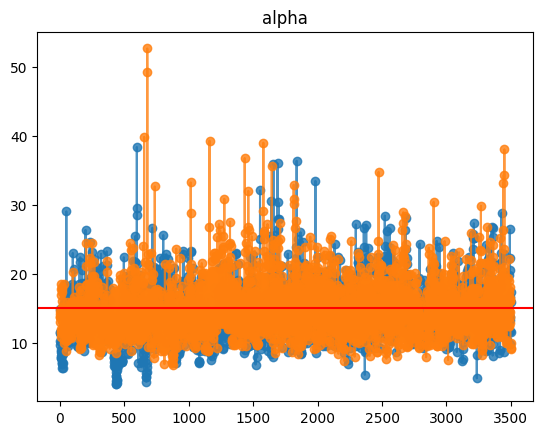

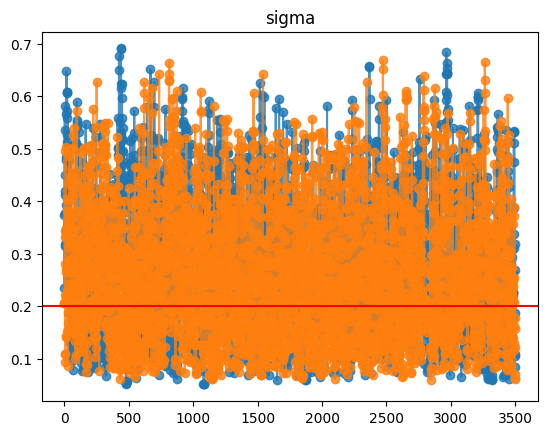

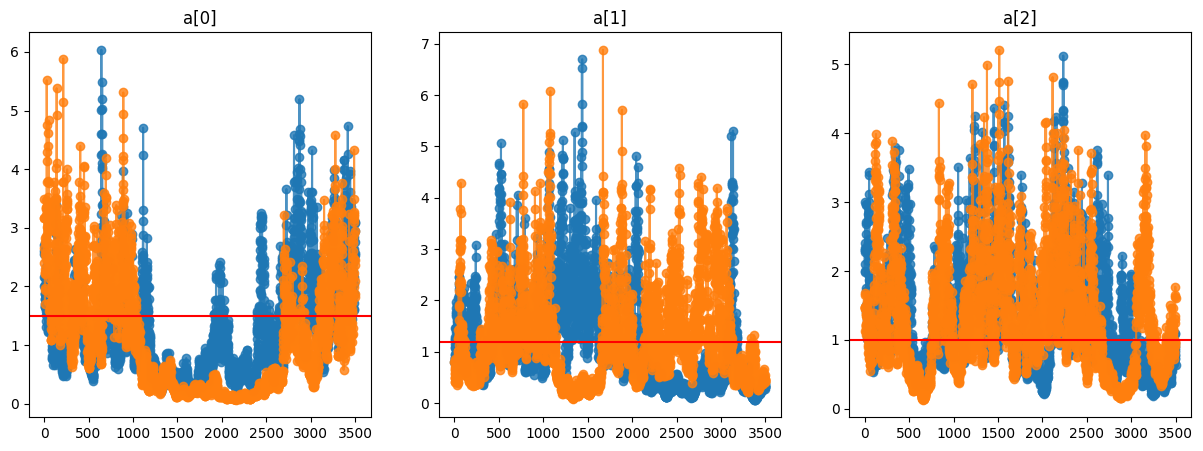

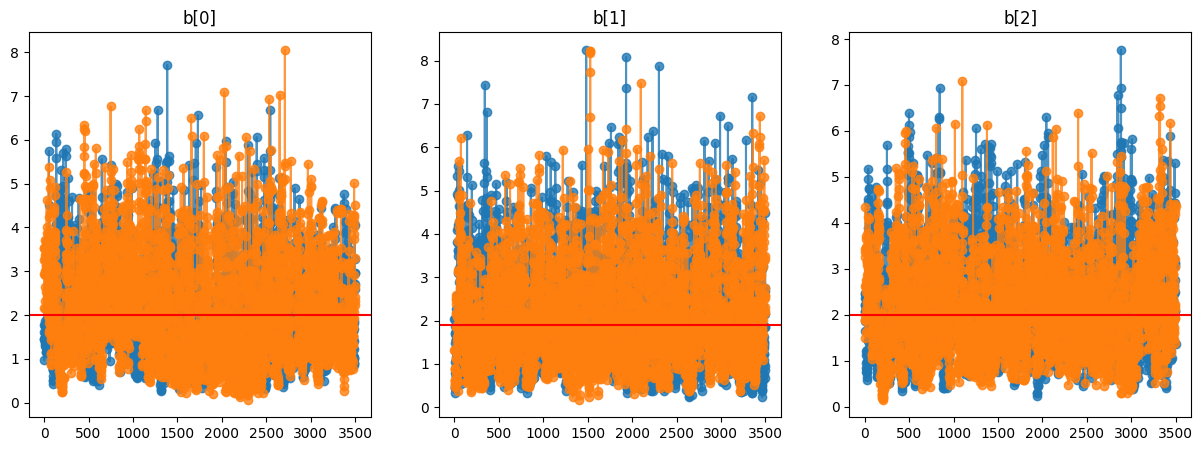

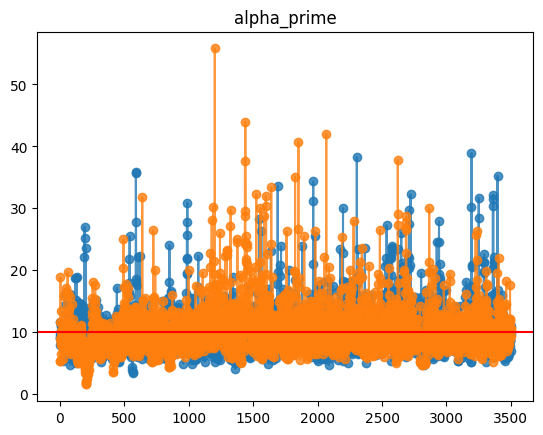

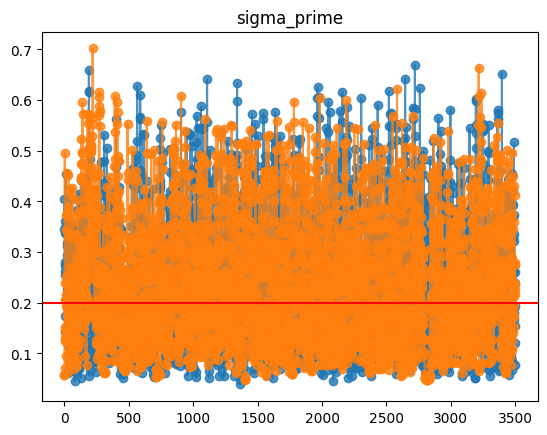

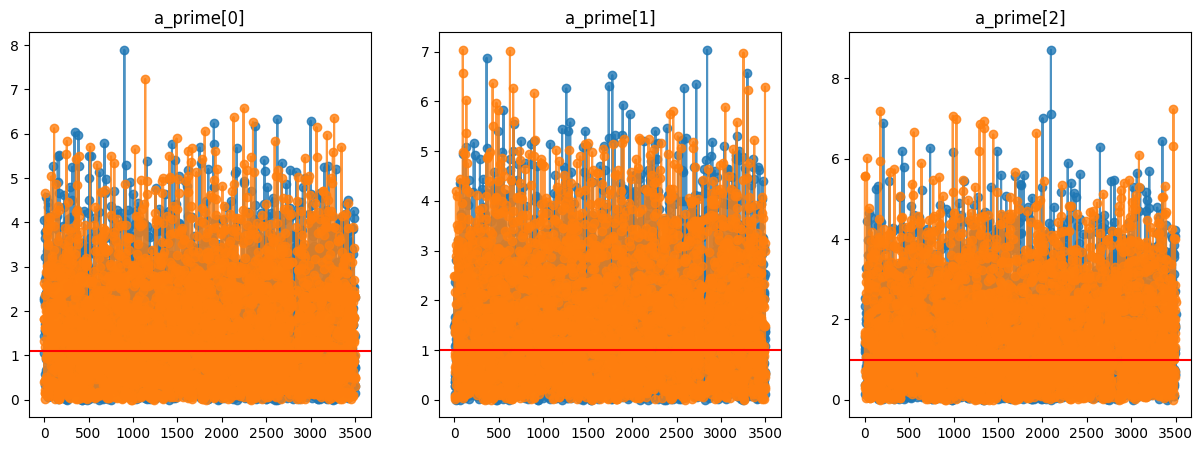

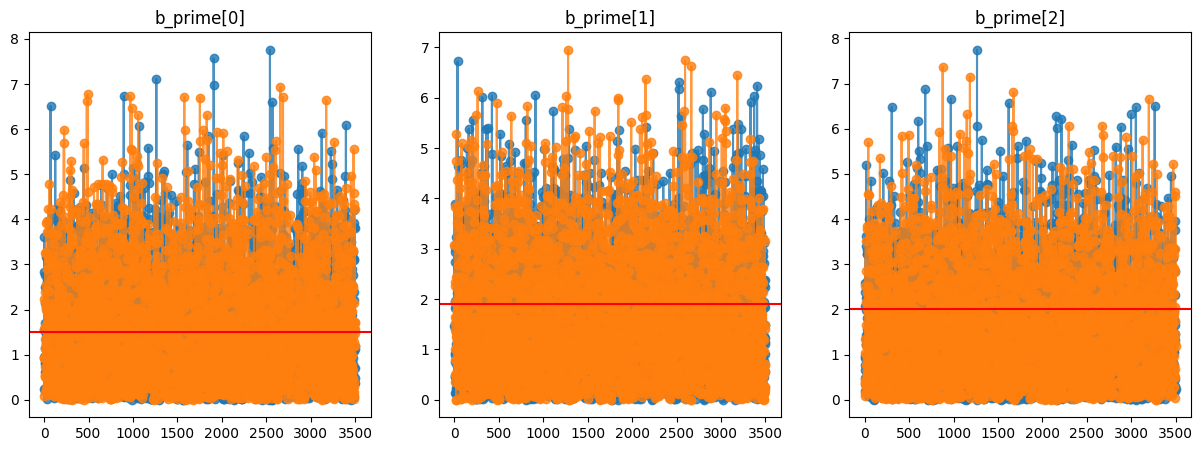

In [36]:
plot_traces(args_mcmc, samples, args)

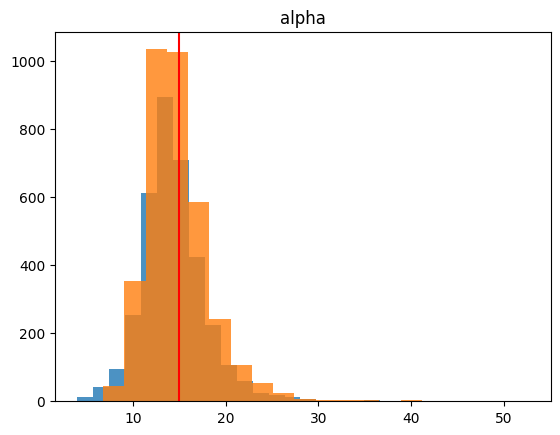

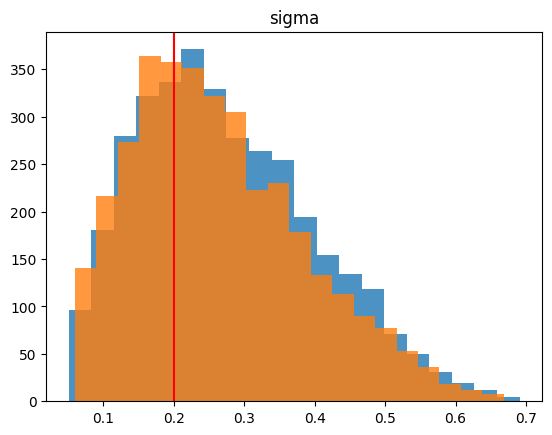

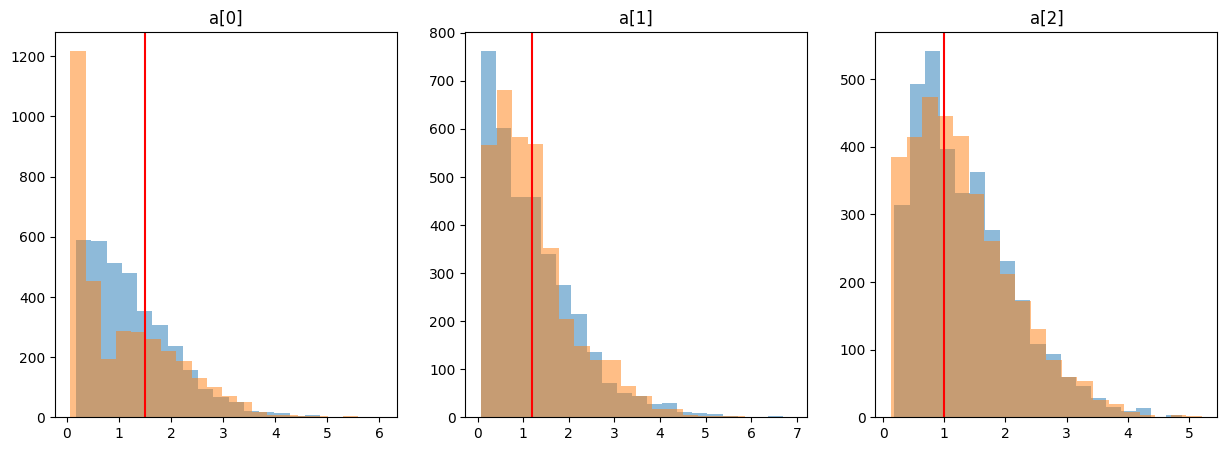

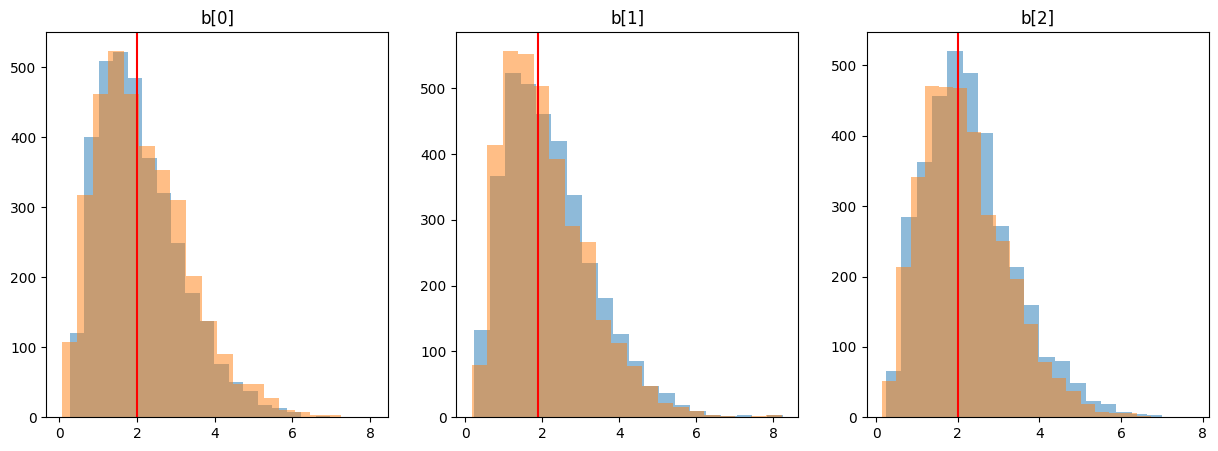

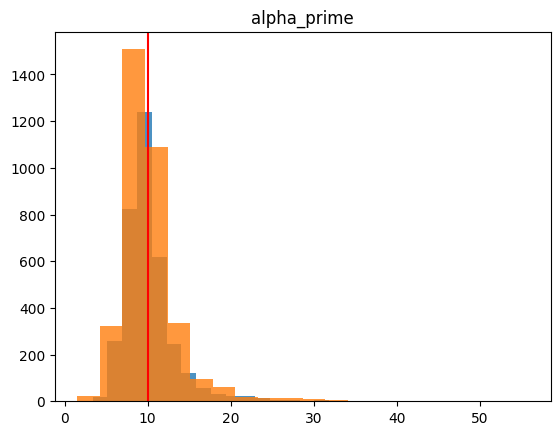

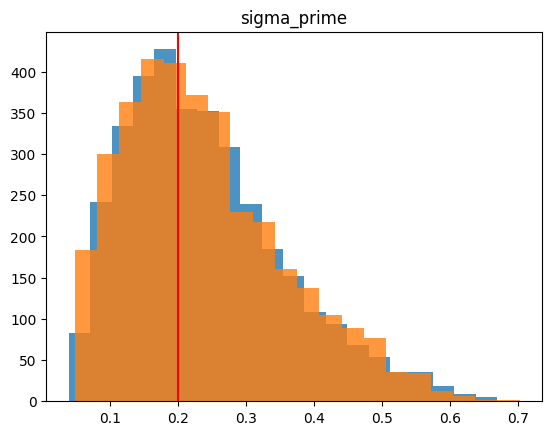

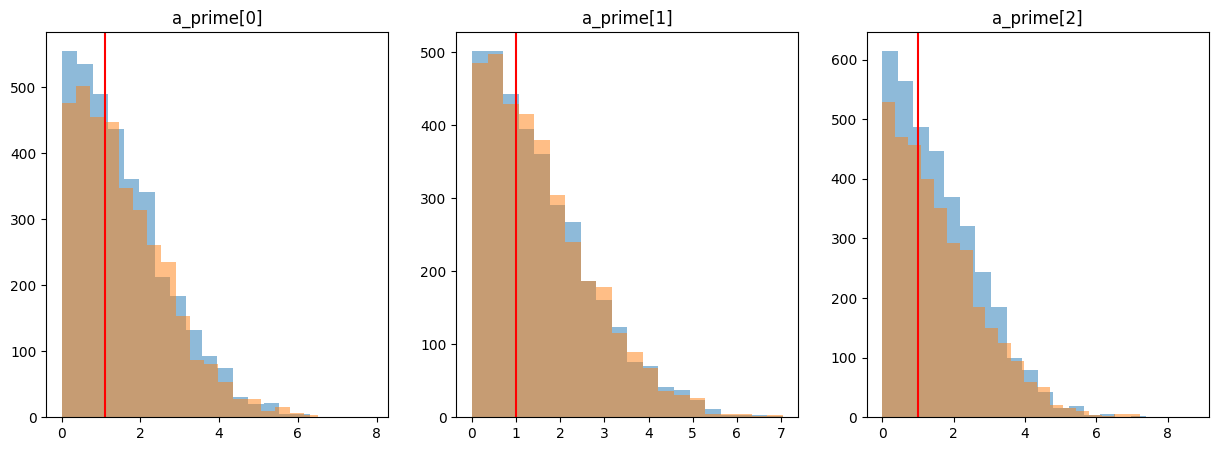

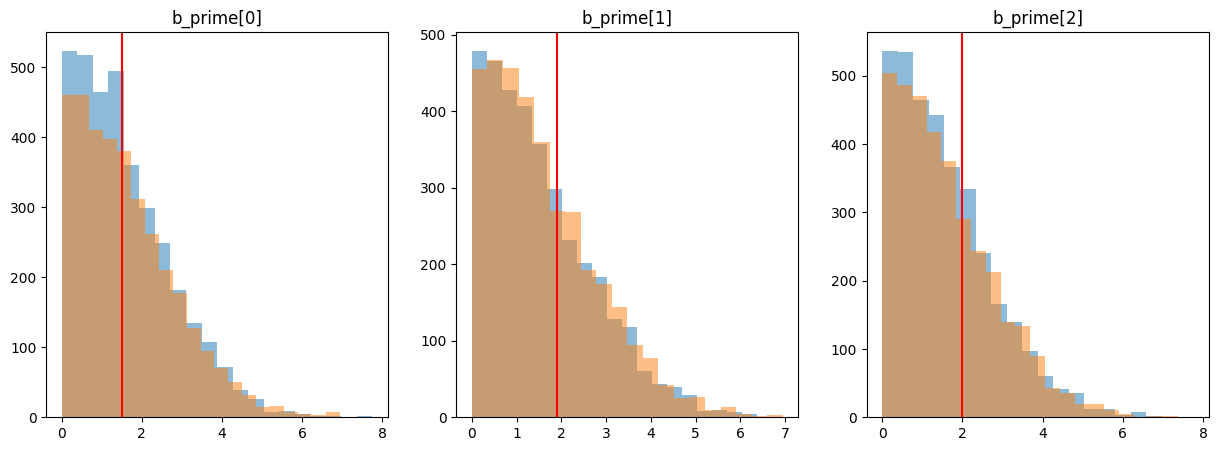

In [37]:
plot_MCMC_histograms(args_mcmc, samples, args)

Wi0 Shape:(2, 198)
Wj0 Shape:(2, 132)


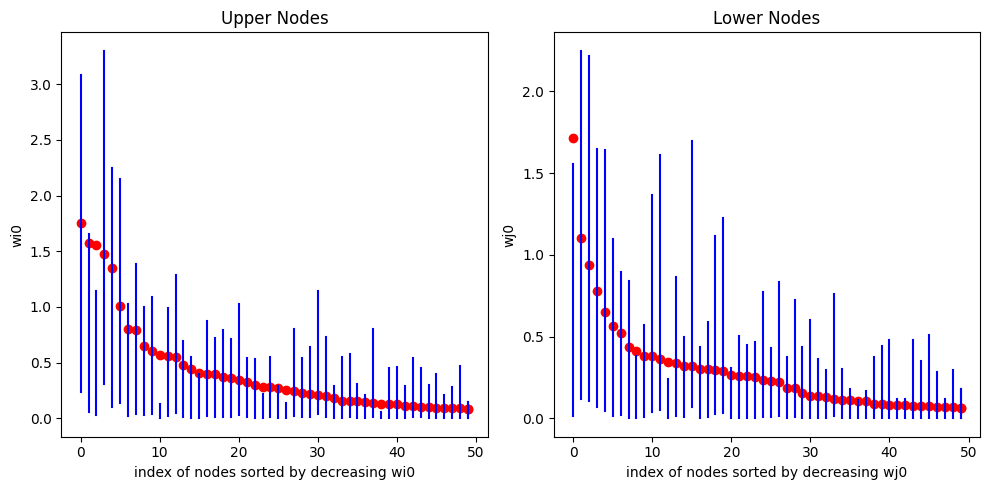

In [38]:
Posterior_distribution(graph_draws = Bipartite_graph_draws,
                       num_samples = num_samples,
                       thinning = thinning,
                       num_chains = num_chains,
                       L = L_mcmc,
                       L_prime = L_prime_mcmc)

Wi0 Shape:(2, 198)
Wj0 Shape:(2, 132)


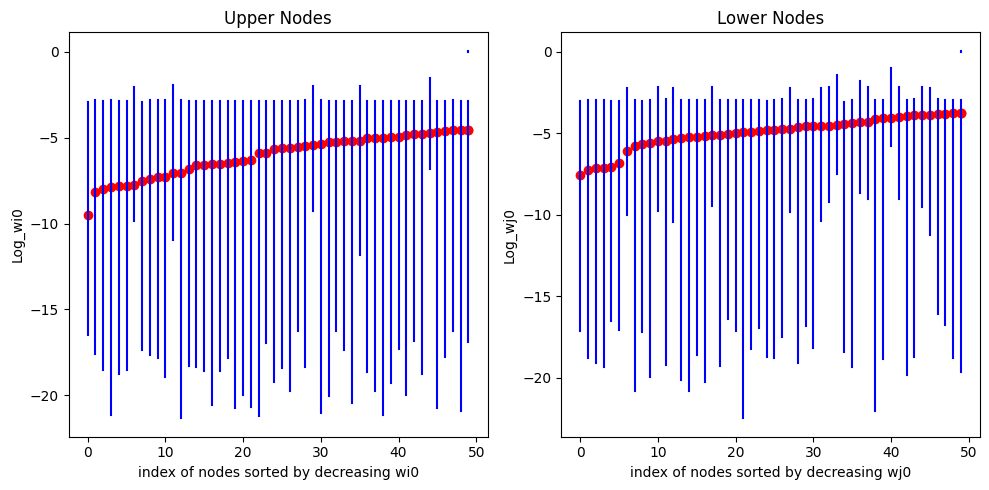

In [39]:
Posterior_distribution_Log(graph_draws = Bipartite_graph_draws,
                       num_samples = num_samples,
                       thinning = thinning,
                       num_chains = num_chains,
                       L = L_mcmc,
                       L_prime = L_prime_mcmc)

No Weights 


<ipython-input-19-b69e0c25b172>:18: UserWarning: Explicitly requested dtype float requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  wi0 = jnp.zeros((L, 1), dtype='float')


(198,)
(132,)
(198, 3)
(132, 3)
(198, 3)
(132, 3)
Wi0:(198,), Wj0:(132,), scores:(198, 3), scores_prime:(132, 3), weights_prime:(132, 3), weights:(198, 3)
N_obs:(198, 132)
Z_obs:(198, 132)
plot_figure Upper
plot_figure Lower


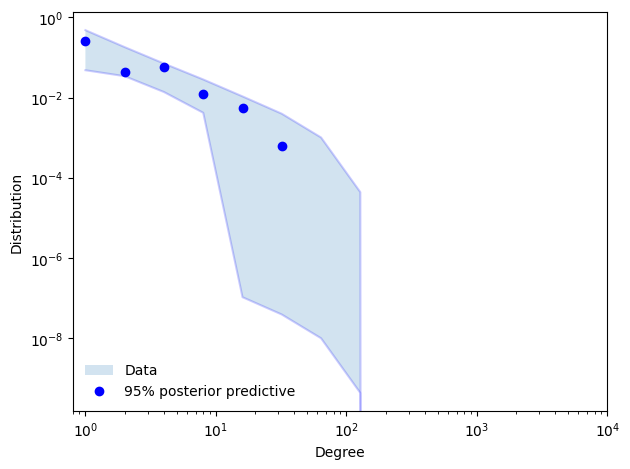

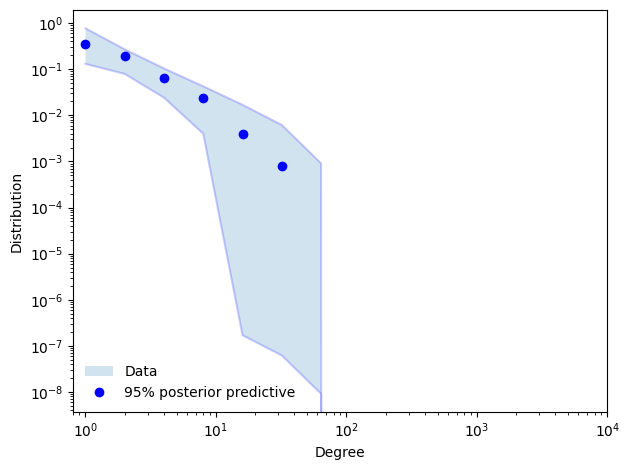

In [40]:
num_draws=500 # change to 500
_, _, _, _, _, _, _, _, _, _ = plot_post_degree_distribution(num_draws = num_draws,
                                                             samples = samples,
                                                             args_dict=args_mcmc,
                                                             original_adj_matrix = adj_matrix,
                                                             use_weights=0)

# 112th US Congress Data

In [ ]:
#mount the drive so that I can read and write on files on my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
mat = scipy.io.loadmat('/content/drive/MyDrive/UCY Data /Copy of 112thUSCongressHouse.mat')

In [ ]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data', 'votes'])

In [ ]:
mat['votes'][0][0].shape, mat['votes'][0][1].shape,  483+326


((451, 483), (451, 326), 809)

In [ ]:
#426 senators and 806 bills

In [ ]:
votes = mat['votes'][0]
# for i, arr in enumerate(votes):
#   votes[i] = arr[~np.isnan(arr).any(axis=1)]

In [ ]:
def remove_no_connections(adj_matrix):
  #Identify rows and columns with zero connections
  zero_connection_rows = np.where(np.sum(adj_matrix, axis=1) == 0)[0]
  zero_connection_columns = np.where(np.sum(adj_matrix, axis=0) == 0)[0]

  #Create a mask for the rows and columns to keep
  keep_rows_mask = np.ones(adj_matrix.shape[0], dtype=bool)
  keep_columns_mask = np.ones(adj_matrix.shape[1], dtype=bool)

  keep_rows_mask[zero_connection_rows] = False
  keep_columns_mask[zero_connection_columns] = False

  #Use the masks to filter the adjacency matrix
  filtered_adj_matrix = adj_matrix[keep_rows_mask][:, keep_columns_mask]
  return filtered_adj_matrix

x = remove_no_connections(adj_matrix)
x.shape

In [ ]:
votes[0]

array([array([[nan,  0.,  0., ...,  1.,  0.,  0.],
              [nan,  1.,  1., ...,  1.,  0.,  0.],
              [nan,  0.,  0., ...,  0.,  1.,  0.],
              ...,
              [nan,  0.,  0., ...,  1.,  1.,  1.],
              [nan,  1.,  1., ...,  1.,  0.,  0.],
              [nan,  1.,  1., ...,  1.,  0.,  0.]]),
       array([[nan,  0.,  1., ...,  1.,  0.,  1.],
              [nan,  1.,  1., ...,  0.,  1.,  0.],
              [nan,  0.,  0., ...,  0.,  1.,  0.],
              ...,
              [nan,  0.,  1., ...,  1.,  1.,  1.],
              [nan,  1.,  0., ...,  0.,  1.,  0.],
              [nan,  1.,  1., ...,  0.,  1.,  0.]])], dtype=object)